In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
os.chdir("/mnt/beegfs/zdong7/our_data/experiments-Feb-1")

In [4]:
from datetime import datetime
import pandas as pd

# Load the data from the file
file_path = 'data/KO.csv'
csv_data = pd.read_csv(file_path)

# Displaying the first few rows of the data to understand its structure
csv_data.head()

,Date,Volume,Open,High,Low,Close,Adj close,Sentiment_gpt,News_flag,Scaled_sentiment
0,2009-10-14 00:00:00+00:00,16081000.0,27.459999,27.514999,27.295000,27.420000,18.121803,2.0,1.0,0.250025
1,2009-10-15 00:00:00+00:00,24241800.0,27.365000,27.605000,27.174999,27.459999,18.148237,3.0,1.0,0.500025
2,2009-10-16 00:00:00+00:00,22090800.0,27.459999,27.600000,27.344999,27.504999,18.177977,3.0,0.0,0.500025
3,2009-10-19 00:00:00+00:00,20656000.0,27.570000,27.750000,27.334999,27.395000,18.105282,3.0,0.0,0.500025
4,2009-10-20 00:00:00+00:00,26859600.0,26.795000,27.075001,26.590000,27.035000,17.867361,3.0,0.0,0.500025


In [5]:

import numpy as np

# Function to create sequences
def create_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:(i + input_length)])
        y.append(data[(i + input_length):(i + input_length + output_length), 2])  # 2 is the index of 'Close' in input_features
    return np.array(X), np.array(y)


# Building the TimesNet Model with corrected architecture
class TimesNet(nn.Module):
    def __init__(self, input_features, sequence_length, output_length, num_layers=4):
        super(TimesNet, self).__init__()
        self.conv_layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = input_features if i == 0 else 64
            self.conv_layers.append(nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1))
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(64 * sequence_length, output_length)

    def forward(self, x):
        for conv in self.conv_layers:
            x = torch.relu(conv(x))
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [6]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def sentiment_predict(csv_data,symbol, num_csvs, pred_flag):
  # Selecting specified columns and normalizing the data
  input_features = ['Volume', 'Open', 'Close', 'Scaled_sentiment']
  csv_data_selected = csv_data[input_features]
  scaler = MinMaxScaler()
  # scaler = RobustScaler()
  csv_data_normalized = scaler.fit_transform(csv_data_selected)
  # print(csv_data_selected)
  # Creating input-output sequences
  input_length = 50
  output_length = 3

  split_ratio = 0.85
  split = int(split_ratio * len(csv_data_normalized))
  data_train = csv_data_normalized[:split]
  data_test = csv_data_normalized[split:]
  # print(len(data_train))
  # print(len(data_test))
  X_train, y_train = create_sequences(data_train, input_length, output_length)
  X_test, y_test = create_sequences(data_test, input_length, output_length)

  # # Splitting the data into training and testing sets

  # X_train, X_test = X[:split], X[split:]
  # y_train, y_test = y[:split], y[split:]


  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  # Instantiate the model with correct input dimensions
  model = TimesNet(4, 50, 3, num_layers=4).to(device)
  model_path = f'model_saved/sentiment_{num_csvs}.pt'

  epochs = 0  # Adjust as needed
  if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded model from {model_path} onto {'CUDA' if torch.cuda.is_available() else 'CPU'}")

  if pred_flag:
    epochs = 50
  else:
    epochs = 100



  # Defining the loss function and optimizer
  loss_function = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Convert numpy arrays to PyTorch tensors and run training for 1 epoch to validate
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).transpose(1, 2).to(device)  # Transposing to match model's input shape
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
  # print("Check")
  # print(X_test_tensor.shape,X_test_tensor[:10])
  # print(y_test_tensor.shape,y_test_tensor)

  batch_size = 64
  num_batches = int(len(X_train) / batch_size)


  # model, loss_function, optimizer

  # Training loop
  model.train()
  for epoch in range(epochs):
      total_loss = 0
      for b in range(num_batches):
          start_index = b * batch_size
          end_index = start_index + batch_size
          x_batch = X_train_tensor[start_index:end_index].to(device)
          y_batch = y_train_tensor[start_index:end_index].to(device)


          # Forward pass
          y_pred = model(x_batch)
          loss = loss_function(y_pred, y_batch)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

      print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / num_batches}")

  print("Training complete.")



  # Save the model
  date_str = datetime.now().strftime("%Y%m%d%H%M")
  os.makedirs(os.path.join("model_saved"), exist_ok=True)
  torch.save(model.state_dict(), model_path)
  print(f"saved model into {model_path}")

  if pred_flag:
    if symbol in pred_names:
      
      # Prediction on test data
      model.eval()
      X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  # Assuming 'device' is already defined and used previously
      X_test_tensor = X_test_tensor.transpose(1, 2)  # Transpose to match model's input shape
      with torch.no_grad():
          y_pred = model(X_test_tensor)

      # Convert predictions to CPU and numpy array
      y_pred_np = y_pred.cpu().numpy()

      # Reshape y_pred_np to have the same shape as y_test for each prediction
      y_pred_reshaped = y_pred_np.reshape(-1, output_length)  # output_length is the number of predicted values (e.g., 3)

      # Flatten y_test and y_pred_reshaped for comparison
      y_test_flattened = y_test.flatten()
      y_pred_flattened = y_pred_reshaped.flatten()
      # print("check")
      # print(y_test_flattened)
      # print(y_pred_flattened)
      # Calculate metrics
      mse = mean_squared_error(y_test_flattened, y_pred_flattened)
      mae = mean_absolute_error(y_test_flattened, y_pred_flattened)
      r2 = r2_score(y_test_flattened, y_pred_flattened)
      print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")
      eval_df = pd.DataFrame({
            'MAE': [mae],
            'MSE': [mse],
            'R2': [r2]
        })

      # Plotting the results
      plt.figure(figsize=(10, 6))
      plt.plot(y_test_flattened, label="Ground Truth", color='blue')
      plt.plot(y_pred_flattened, label="Predicted", color='red')
      plt.title("Ground Truth vs Predicted")
      plt.xlabel("Time Steps")
      plt.ylabel("Values")
      plt.legend()
      plt.show()
        # 创建一个形状为 [-1, 4] 的全零数组
      y_test_expanded = np.zeros((y_test_flattened.shape[0], 4))
      y_pred_expanded = np.zeros((y_pred_flattened.shape[0], 4))

      # 将原始数据放在第三列（索引为2）
      y_test_expanded[:, 2] = y_test_flattened
      y_pred_expanded[:, 2] = y_pred_flattened
      y_test_origin = scaler.inverse_transform(y_test_expanded)[:, 2]
      y_pred_origin = scaler.inverse_transform(y_pred_expanded)[:, 2]
      # print(y_test_origin)
      # print("___")
      # print(y_pred_origin)
      # Save the results to a CSV file
      predicted_data_results = pd.DataFrame({'True_Data': y_test_flattened, 'Predicted_Data': y_pred_flattened, 'True_Data_origin': y_test_origin, 'Predicted_Data_origin': y_pred_origin},)
      saving_folder = os.path.join(f"test_result_{num_csvs}",f"{symbol}_sentiment_{date_str}")
      os.makedirs(saving_folder, exist_ok=True)
      predicted_data_results_save_path = os.path.join(saving_folder, f'{symbol}_sentiment_{date_str}_predicted_data.csv')
      predicted_data_results.to_csv(predicted_data_results_save_path, index=False)

      os.makedirs(saving_folder, exist_ok=True)
      eval_df_save_path = os.path.join(saving_folder, f'{symbol}_sentiment_{date_str}_eval_data.csv')
      eval_df.to_csv(eval_df_save_path, index=False)
      print(f"saved predictions and evals to {predicted_data_results_save_path} and {eval_df_save_path}")

In [8]:
def nonsentiment_predict(csv_data,symbol, num_csvs, pred_flag):
  # Selecting specified columns and normalizing the data
  input_features = ['Volume', 'Open', 'Close']
  csv_data_selected = csv_data[input_features]
  scaler = MinMaxScaler()
  # scaler = RobustScaler()
  csv_data_normalized = scaler.fit_transform(csv_data_selected)
  # Creating input-output sequences
  input_length = 50
  output_length = 3

  split_ratio = 0.85
  split = int(split_ratio * len(csv_data_normalized))
  data_train = csv_data_normalized[:split]
  data_test = csv_data_normalized[split:]
  # print(len(data_train))
  # print(len(data_test))
  X_train, y_train = create_sequences(data_train, input_length, output_length)
  X_test, y_test = create_sequences(data_test, input_length, output_length)

  # # Splitting the data into training and testing sets

  # X_train, X_test = X[:split], X[split:]
  # y_train, y_test = y[:split], y[split:]


  X_train.shape, y_train.shape, X_test.shape, y_test.shape
  # Instantiate the model with correct input dimensions
  model = TimesNet(3, 50, 3, num_layers=4).to(device)
  model_path = f'model_saved/nonsentiment_{num_csvs}.pt'

  epochs = 0  # Adjust as needed
  if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded model from {model_path} onto {'CUDA' if torch.cuda.is_available() else 'CPU'}")

  if pred_flag:
    epochs = 50
  else:
    epochs = 100

  # model.load_state_dict(torch.load(model_path, map_location=device))


  # Defining the loss function and optimizer
  loss_function = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Convert numpy arrays to PyTorch tensors and run training for 1 epoch to validate
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).transpose(1, 2)  # Transposing to match model's input shape
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

  batch_size = 64
  num_batches = int(len(X_train) / batch_size)


  model, loss_function, optimizer

  # Training loop
  model.train()
  for epoch in range(epochs):
      total_loss = 0
      for b in range(num_batches):
          start_index = b * batch_size
          end_index = start_index + batch_size
          x_batch = X_train_tensor[start_index:end_index].to(device)
          y_batch = y_train_tensor[start_index:end_index].to(device)


          # Forward pass
          y_pred = model(x_batch)
          loss = loss_function(y_pred, y_batch)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

      print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / num_batches}")

  print("Training complete.")



  # Save the model
  date_str = datetime.now().strftime("%Y%m%d%H%M")
  os.makedirs(os.path.join("model_saved"), exist_ok=True)
  torch.save(model.state_dict(), model_path)
  print(f"saved model into {model_path}")

  if pred_flag:
    print(pred_names)
    if symbol in pred_names:
      # Prediction on test data
      model.eval()
      X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  # Assuming 'device' is already defined and used previously
      X_test_tensor = X_test_tensor.transpose(1, 2)  # Transpose to match model's input shape
      
      with torch.no_grad():
          y_pred = model(X_test_tensor)

      # Convert predictions to CPU and numpy array
      y_pred_np = y_pred.cpu().numpy()

      # Reshape y_pred_np to have the same shape as y_test for each prediction
      y_pred_reshaped = y_pred_np.reshape(-1, output_length)  # output_length is the number of predicted values (e.g., 3)

      # Flatten y_test and y_pred_reshaped for comparison
      y_test_flattened = y_test.flatten()
      y_pred_flattened = y_pred_reshaped.flatten()
      # Calculate metrics
      mse = mean_squared_error(y_test_flattened, y_pred_flattened)
      mae = mean_absolute_error(y_test_flattened, y_pred_flattened)
      r2 = r2_score(y_test_flattened, y_pred_flattened)
      print(f"MSE: {mse}, MAE: {mae}, R^2: {r2}")
      eval_df = pd.DataFrame({
            'MAE': [mae],
            'MSE': [mse],
            'R2': [r2]
        })

      # Plotting the results
      plt.figure(figsize=(10, 6))
      plt.plot(y_test_flattened, label="Ground Truth", color='blue')
      plt.plot(y_pred_flattened, label="Predicted", color='red')
      plt.title("Ground Truth vs Predicted")
      plt.xlabel("Time Steps")
      plt.ylabel("Values")
      plt.legend()
      plt.show()
        # 创建一个形状为 [-1, 3] 的全零数组
      y_test_expanded = np.zeros((y_test_flattened.shape[0], 3))
      y_pred_expanded = np.zeros((y_pred_flattened.shape[0], 3))

      # 将原始数据放在第三列（索引为2）
      y_test_expanded[:, 2] = y_test_flattened
      y_pred_expanded[:, 2] = y_pred_flattened
      y_test_origin = scaler.inverse_transform(y_test_expanded)[:, 2]
      y_pred_origin = scaler.inverse_transform(y_pred_expanded)[:, 2]
      # print(y_test_origin)
      # print("___")
      # print(y_pred_origin)
      # Save the results to a CSV file
      predicted_data_results = pd.DataFrame({'True_Data': y_test_flattened, 'Predicted_Data': y_pred_flattened, 'True_Data_origin': y_test_origin, 'Predicted_Data_origin': y_pred_origin},)
      saving_folder = os.path.join(f"test_result_{num_csvs}",f"{symbol}_nonsentiment_{date_str}")
      os.makedirs(saving_folder, exist_ok=True)
      predicted_data_results_save_path = os.path.join(saving_folder, f'{symbol}_nonsentiment_{date_str}_predicted_data.csv')
      predicted_data_results.to_csv(predicted_data_results_save_path, index=False)

      os.makedirs(saving_folder, exist_ok=True)
      eval_df_save_path = os.path.join(saving_folder, f'{symbol}_nonsentiment_{date_str}_eval_data.csv')
      eval_df.to_csv(eval_df_save_path, index=False)
      print(f"saved predictions and evals to {predicted_data_results_save_path} and {eval_df_save_path}")

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch 4/100, Loss: 0.0013075054188160912
Epoch 5/100, Loss: 0.001296149229777879
Epoch 6/100, Loss: 0.0013211214528909248
Epoch 7/100, Loss: 0.0012888084747828543
Epoch 8/100, Loss: 0.0012490529334172606
Epoch 9/100, Loss: 0.001200510700551891
Epoch 10/100, Loss: 0.0011760973138734698
Epoch 11/100, Loss: 0.0011506788294737863
Epoch 12/100, Loss: 0.0011303945732499031
Epoch 13/100, Loss: 0.0011061103401803656
Epoch 14/100, Loss: 0.0010719098683789764
Epoch 15/100, Loss: 0.0010499231100670602
Epoch 16/100, Loss: 0.0010335107937479687
Epoch 17/100, Loss: 0.0010219165951160616
Epoch 18/100, Loss: 0.0010205354284201014
Epoch 19/100, Loss: 0.0010185866604412073
Epoch 20/100, Loss: 0.0010259919018656212
Epoch 21/100, Loss: 0.0010273547714429075
Epoch 22/100, Loss: 0.0010346124595104669
Epoch 23/100, Loss: 0.0010201834803937298
Epoch 24/100, Loss: 0.0009907149207337123
Epoch 25/100, Loss: 0.000965943108128972
Epoch 26/100, Loss: 0.0009622134905504552
Epoch 27/100, Lo

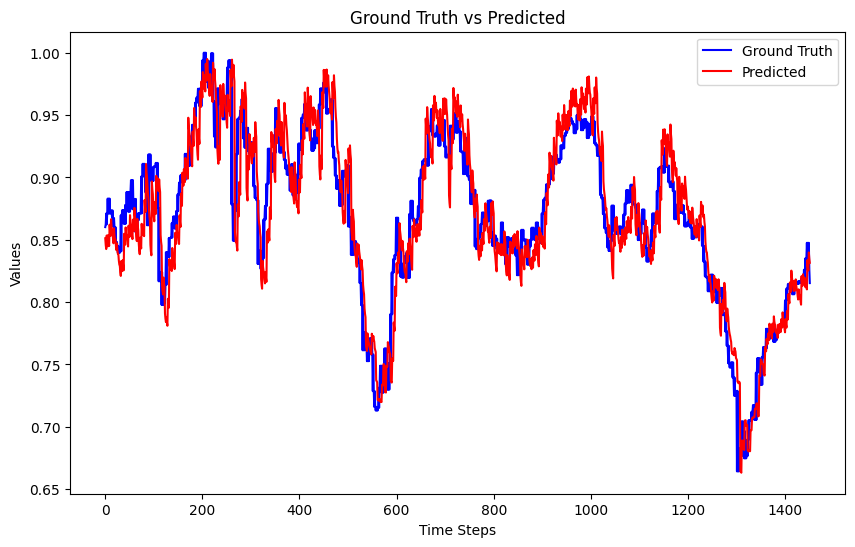

saved predictions and evals to test_result_25/KO_sentiment_202402010402/KO_sentiment_202402010402_predicted_data.csv and test_result_25/KO_sentiment_202402010402/KO_sentiment_202402010402_eval_data.csv
Loaded model from model_saved/nonsentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.0003107681762270184
Epoch 2/50, Loss: 0.0003153182173580559
Epoch 3/50, Loss: 0.0003024419603879442
Epoch 4/50, Loss: 0.00032332347362408535
Epoch 5/50, Loss: 0.0002997155243065208
Epoch 6/50, Loss: 0.0002739367984126464
Epoch 7/50, Loss: 0.00026968344109659284
Epoch 8/50, Loss: 0.0002642037576626298
Epoch 9/50, Loss: 0.0002653193449710354
Epoch 10/50, Loss: 0.00026725182349606337
Epoch 11/50, Loss: 0.00026979799535500047
Epoch 12/50, Loss: 0.0002680847559848031
Epoch 13/50, Loss: 0.0002760124105248985
Epoch 14/50, Loss: 0.0002750657639135961
Epoch 15/50, Loss: 0.00026982419038414145
Epoch 16/50, Loss: 0.0002806966427749063
Epoch 17/50, Loss: 0.0002938090316171798
Epoch 18/50, Loss: 0.0003018836786909758
Epoch

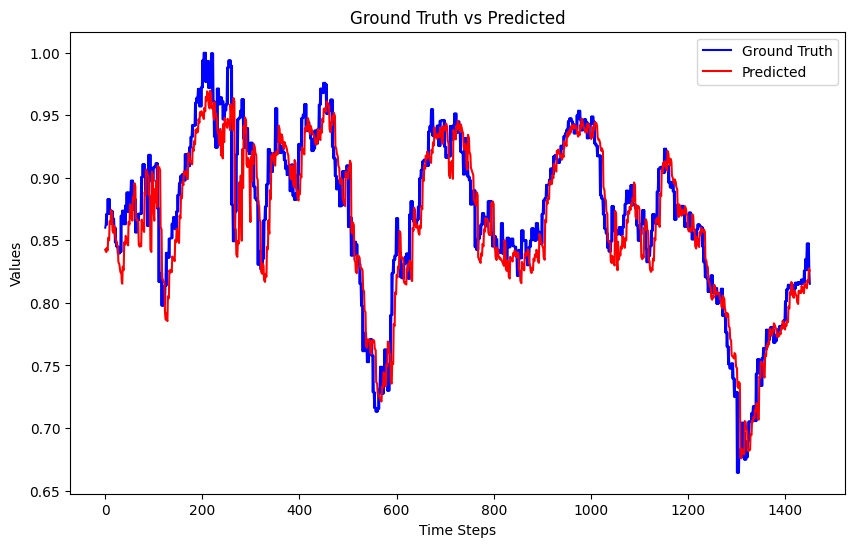

saved predictions and evals to test_result_25/KO_nonsentiment_202402010402/KO_nonsentiment_202402010402_predicted_data.csv and test_result_25/KO_nonsentiment_202402010402/KO_nonsentiment_202402010402_eval_data.csv
AMD
Loaded model from model_saved/sentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.00048470578423637727
Epoch 2/50, Loss: 0.0004749159458945294
Epoch 3/50, Loss: 0.0009218737356026064
Epoch 4/50, Loss: 0.0005421476086088329
Epoch 5/50, Loss: 0.0005262863877843218
Epoch 6/50, Loss: 0.0006463587274497099
Epoch 7/50, Loss: 0.0004319159877261634
Epoch 8/50, Loss: 0.0004788359080769376
Epoch 9/50, Loss: 0.0004764006897113921
Epoch 10/50, Loss: 0.0006182546689656606
Epoch 11/50, Loss: 0.0007227440893819386
Epoch 12/50, Loss: 0.000652516748893752
Epoch 13/50, Loss: 0.0005680091035173973
Epoch 14/50, Loss: 0.0004903279143697794
Epoch 15/50, Loss: 0.00046521956342489415
Epoch 16/50, Loss: 0.0004179621229757851
Epoch 17/50, Loss: 0.00041193376075005455
Epoch 18/50, Loss: 0.000415454709747

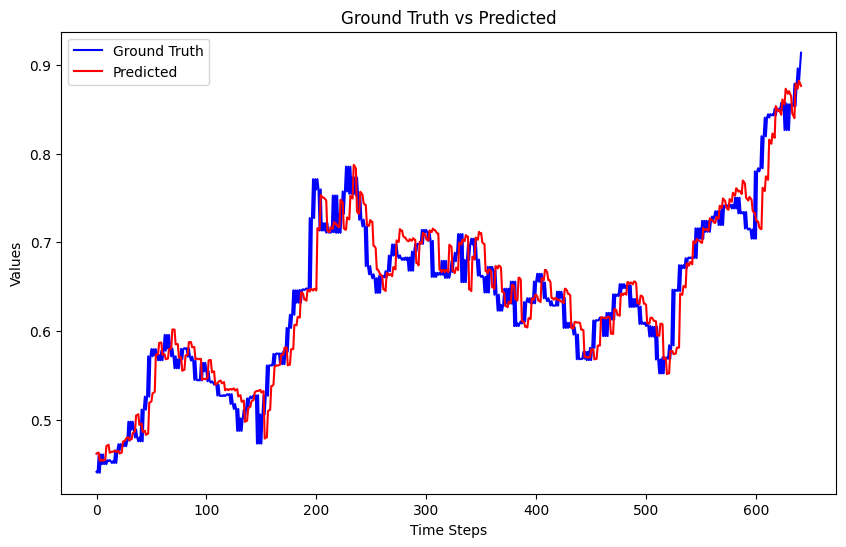

saved predictions and evals to test_result_25/AMD_sentiment_202402010402/AMD_sentiment_202402010402_predicted_data.csv and test_result_25/AMD_sentiment_202402010402/AMD_sentiment_202402010402_eval_data.csv
Loaded model from model_saved/nonsentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.0004998474292237502
Epoch 2/50, Loss: 0.0005364430297215057
Epoch 3/50, Loss: 0.0006086220004859074
Epoch 4/50, Loss: 0.0008756925748126708
Epoch 5/50, Loss: 0.0010155298229867847
Epoch 6/50, Loss: 0.0008952470366652547
Epoch 7/50, Loss: 0.0006184000217630951
Epoch 8/50, Loss: 0.0006151638582113347
Epoch 9/50, Loss: 0.0006303597772123546
Epoch 10/50, Loss: 0.0006379863838942997
Epoch 11/50, Loss: 0.0006942897089174949
Epoch 12/50, Loss: 0.0005174038560653571
Epoch 13/50, Loss: 0.0005160979868709215
Epoch 14/50, Loss: 0.00048674237901154396
Epoch 15/50, Loss: 0.0005284805482171413
Epoch 16/50, Loss: 0.0006040073031644253
Epoch 17/50, Loss: 0.0005056678313518536
Epoch 18/50, Loss: 0.0004909146902553567
Epoch

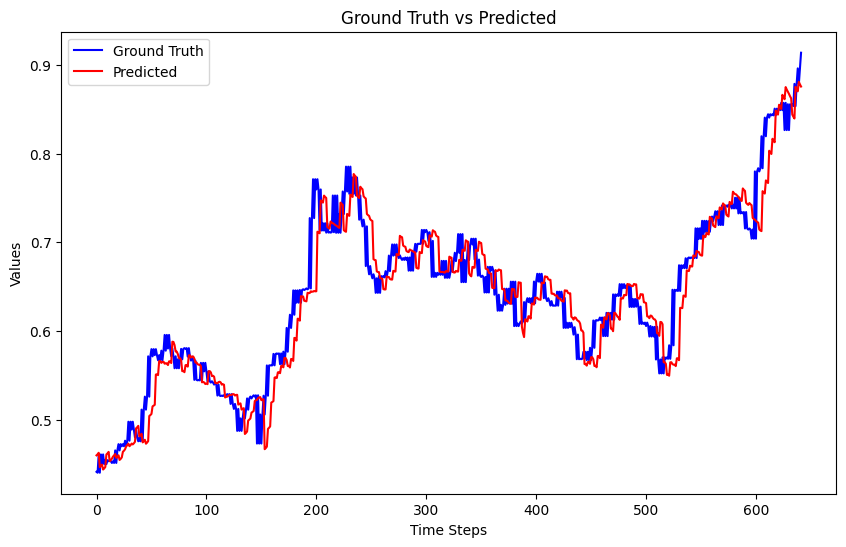

saved predictions and evals to test_result_25/AMD_nonsentiment_202402010402/AMD_nonsentiment_202402010402_predicted_data.csv and test_result_25/AMD_nonsentiment_202402010402/AMD_nonsentiment_202402010402_eval_data.csv
TSM
Loaded model from model_saved/sentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.00016092231521724898
Epoch 2/50, Loss: 0.00014440548176770045
Epoch 3/50, Loss: 0.0002386222125675307
Epoch 4/50, Loss: 0.0005765009879971992
Epoch 5/50, Loss: 0.0006880087886946222
Epoch 6/50, Loss: 0.0005232940276404075
Epoch 7/50, Loss: 0.00028804086766533806
Epoch 8/50, Loss: 0.0001343448020427538
Epoch 9/50, Loss: 0.00010174017664997915
Epoch 10/50, Loss: 9.013799057232642e-05
Epoch 11/50, Loss: 9.307643049603278e-05
Epoch 12/50, Loss: 8.913045858414328e-05
Epoch 13/50, Loss: 9.631553925001671e-05
Epoch 14/50, Loss: 9.700587099814584e-05
Epoch 15/50, Loss: 0.00013149803972241486
Epoch 16/50, Loss: 0.00018527911645998591
Epoch 17/50, Loss: 0.0003679756551016246
Epoch 18/50, Loss: 0.0004691

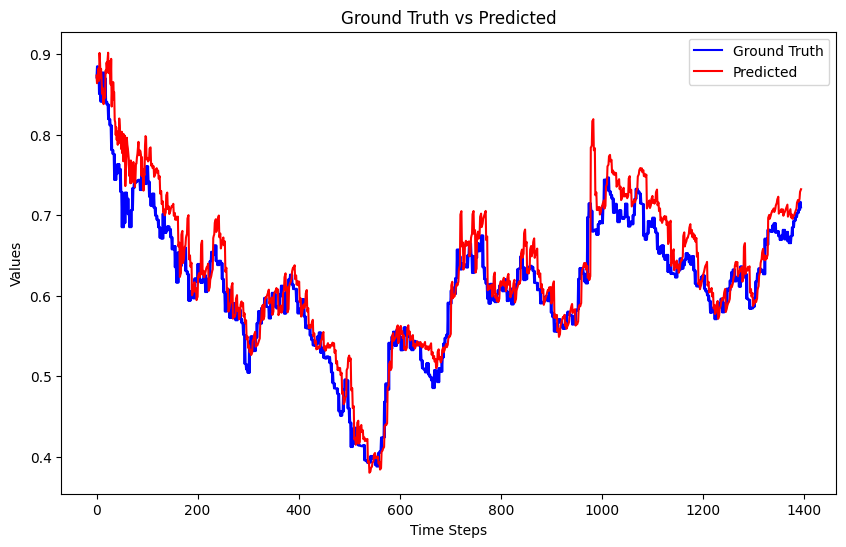

saved predictions and evals to test_result_25/TSM_sentiment_202402010402/TSM_sentiment_202402010402_predicted_data.csv and test_result_25/TSM_sentiment_202402010402/TSM_sentiment_202402010402_eval_data.csv
Loaded model from model_saved/nonsentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.0001235566856662858
Epoch 2/50, Loss: 0.00019353868468773396
Epoch 3/50, Loss: 0.00040609924053569557
Epoch 4/50, Loss: 0.0007495595302977811
Epoch 5/50, Loss: 0.00041623622384825217
Epoch 6/50, Loss: 0.00044709161759535414
Epoch 7/50, Loss: 0.00014795109931045855
Epoch 8/50, Loss: 0.00020130249544598138
Epoch 9/50, Loss: 0.0001386932032119148
Epoch 10/50, Loss: 0.00017591852788841194
Epoch 11/50, Loss: 0.00017263945046992873
Epoch 12/50, Loss: 0.0002050765621003269
Epoch 13/50, Loss: 0.00026023854951001175
Epoch 14/50, Loss: 0.00030444996882165884
Epoch 15/50, Loss: 0.00041497565240950445
Epoch 16/50, Loss: 0.0004122548069434825
Epoch 17/50, Loss: 0.0005193351761260022
Epoch 18/50, Loss: 0.000395659811725

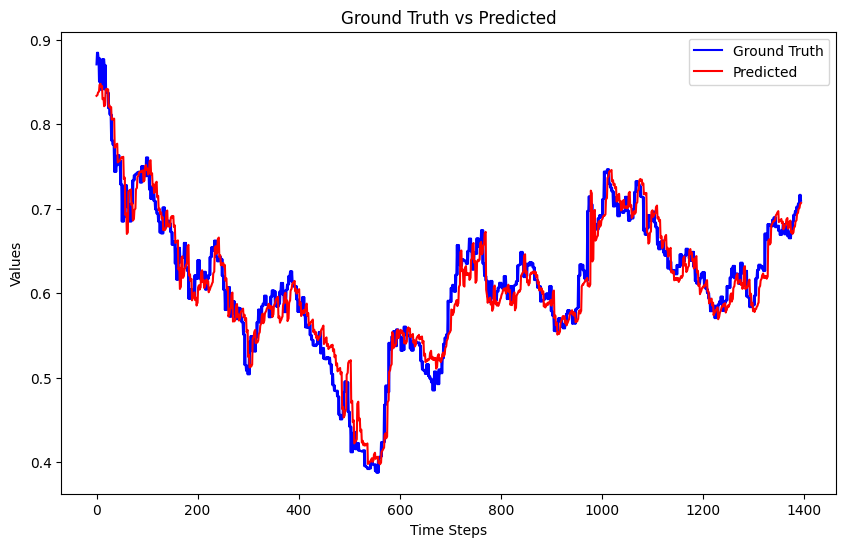

saved predictions and evals to test_result_25/TSM_nonsentiment_202402010402/TSM_nonsentiment_202402010402_predicted_data.csv and test_result_25/TSM_nonsentiment_202402010402/TSM_nonsentiment_202402010402_eval_data.csv
GOOG
Loaded model from model_saved/sentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.0023117291020753328
Epoch 2/50, Loss: 0.0020724746613874838
Epoch 3/50, Loss: 0.001997335794294486
Epoch 4/50, Loss: 0.001982243718157406
Epoch 5/50, Loss: 0.0019769054280307802
Epoch 6/50, Loss: 0.0019679166984436355
Epoch 7/50, Loss: 0.001964737048850414
Epoch 8/50, Loss: 0.0019616471651412817
Epoch 9/50, Loss: 0.001959406555852183
Epoch 10/50, Loss: 0.001956290537721846
Epoch 11/50, Loss: 0.0019533795497712466
Epoch 12/50, Loss: 0.0019524945017413604
Epoch 13/50, Loss: 0.001958210446900921
Epoch 14/50, Loss: 0.001969855275789693
Epoch 15/50, Loss: 0.0019894917823573147
Epoch 16/50, Loss: 0.002043477175478377
Epoch 17/50, Loss: 0.0020676407849047488
Epoch 18/50, Loss: 0.0021397280380673084


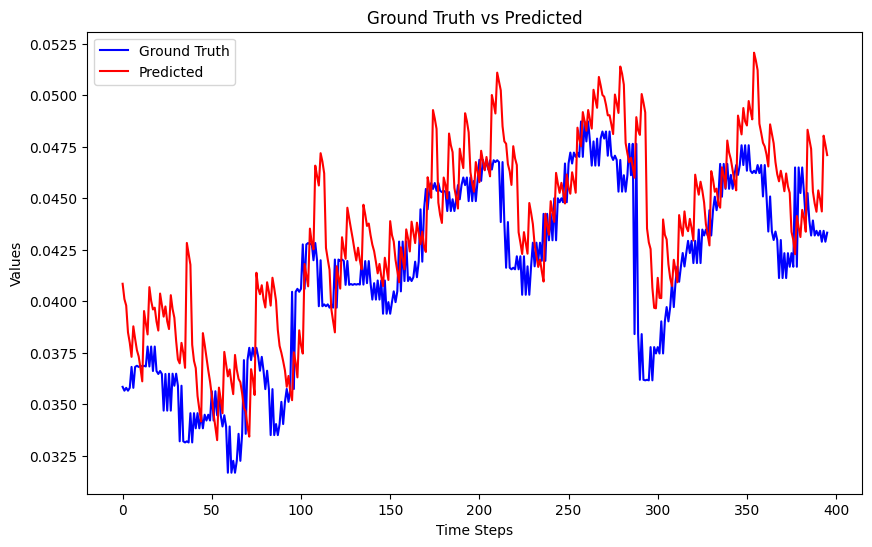

saved predictions and evals to test_result_25/GOOG_sentiment_202402010402/GOOG_sentiment_202402010402_predicted_data.csv and test_result_25/GOOG_sentiment_202402010402/GOOG_sentiment_202402010402_eval_data.csv
Loaded model from model_saved/nonsentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.0026260118664746795
Epoch 2/50, Loss: 0.002364269851144248
Epoch 3/50, Loss: 0.002171159516668316
Epoch 4/50, Loss: 0.002076903268607566
Epoch 5/50, Loss: 0.0020266050880309193
Epoch 6/50, Loss: 0.0019905230905351346
Epoch 7/50, Loss: 0.0019724464115218627
Epoch 8/50, Loss: 0.001967029234765505
Epoch 9/50, Loss: 0.001959683936365764
Epoch 10/50, Loss: 0.001965084069252043
Epoch 11/50, Loss: 0.0019621207411546493
Epoch 12/50, Loss: 0.0019699862935946538
Epoch 13/50, Loss: 0.001966824501626737
Epoch 14/50, Loss: 0.0019792857370399966
Epoch 15/50, Loss: 0.0019792990015654746
Epoch 16/50, Loss: 0.0019983508849084806
Epoch 17/50, Loss: 0.0020017793383885875
Epoch 18/50, Loss: 0.002025503033322214
Epoch 19/5

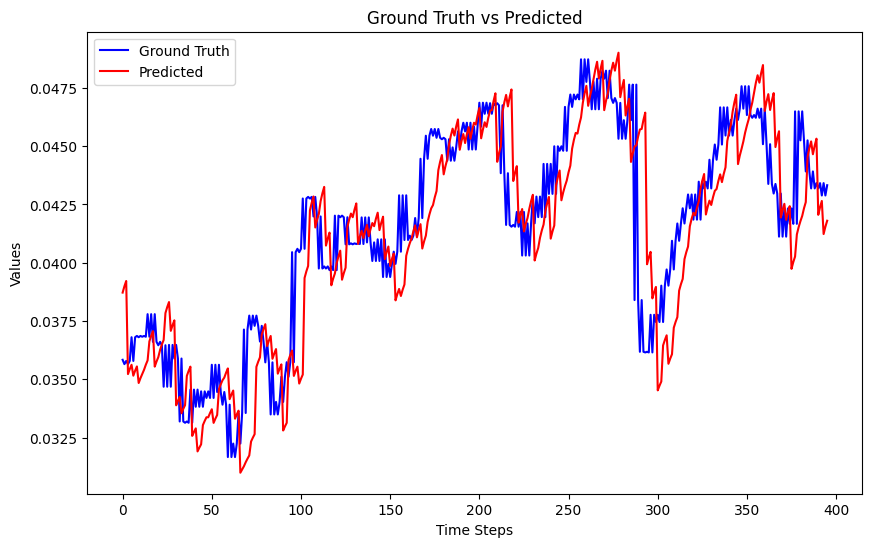

saved predictions and evals to test_result_25/GOOG_nonsentiment_202402010402/GOOG_nonsentiment_202402010402_predicted_data.csv and test_result_25/GOOG_nonsentiment_202402010402/GOOG_nonsentiment_202402010402_eval_data.csv
WMT
Loaded model from model_saved/sentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.0011393084732844727
Epoch 2/50, Loss: 0.0010260989311063895
Epoch 3/50, Loss: 0.0009761444616742665
Epoch 4/50, Loss: 0.0009904343114612857
Epoch 5/50, Loss: 0.0009574176374371746
Epoch 6/50, Loss: 0.0009404958227605675
Epoch 7/50, Loss: 0.0009576431320965639
Epoch 8/50, Loss: 0.0009344166983282776
Epoch 9/50, Loss: 0.0009288400788136641
Epoch 10/50, Loss: 0.000924853148717375
Epoch 11/50, Loss: 0.0009226556330759195
Epoch 12/50, Loss: 0.0009255624345314573
Epoch 13/50, Loss: 0.0009236129153578077
Epoch 14/50, Loss: 0.0009127893572440371
Epoch 15/50, Loss: 0.0009135271075138007
Epoch 16/50, Loss: 0.0009089385730476351
Epoch 17/50, Loss: 0.0009189737975248136
Epoch 18/50, Loss: 0.0009095684

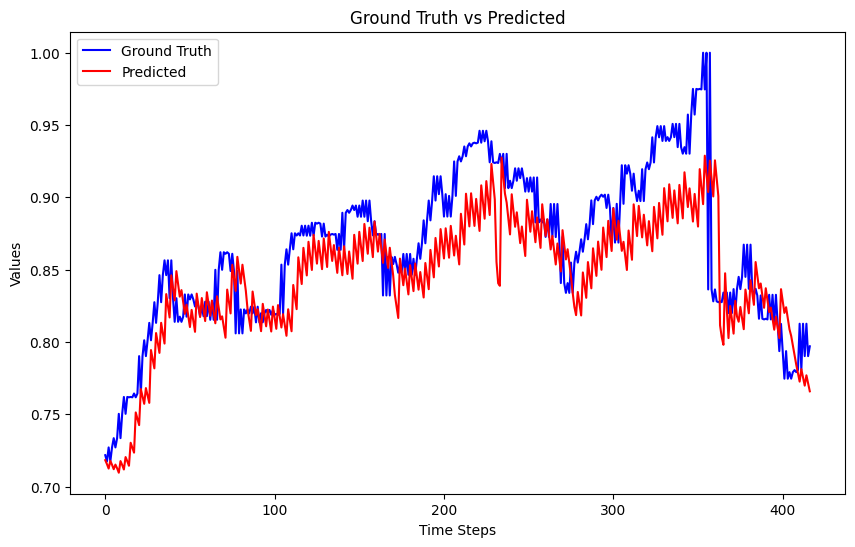

saved predictions and evals to test_result_25/WMT_sentiment_202402010402/WMT_sentiment_202402010402_predicted_data.csv and test_result_25/WMT_sentiment_202402010402/WMT_sentiment_202402010402_eval_data.csv
Loaded model from model_saved/nonsentiment_25.pt onto CUDA
Epoch 1/50, Loss: 0.0010103509957843926
Epoch 2/50, Loss: 0.0009455632562094252
Epoch 3/50, Loss: 0.0009667541962699033
Epoch 4/50, Loss: 0.0009247621510439785
Epoch 5/50, Loss: 0.0009209590343743912
Epoch 6/50, Loss: 0.0009126456880039768
Epoch 7/50, Loss: 0.0009146413412963739
Epoch 8/50, Loss: 0.0009052905325006577
Epoch 9/50, Loss: 0.0009101242922042729
Epoch 10/50, Loss: 0.0009007378002934274
Epoch 11/50, Loss: 0.0009028290496644331
Epoch 12/50, Loss: 0.0008950764067776618
Epoch 13/50, Loss: 0.0008954687709774589
Epoch 14/50, Loss: 0.000890032087227155
Epoch 15/50, Loss: 0.0008928903653213638
Epoch 16/50, Loss: 0.0008865084919307264
Epoch 17/50, Loss: 0.0008892982023098739
Epoch 18/50, Loss: 0.000881633803146542
Epoch 19

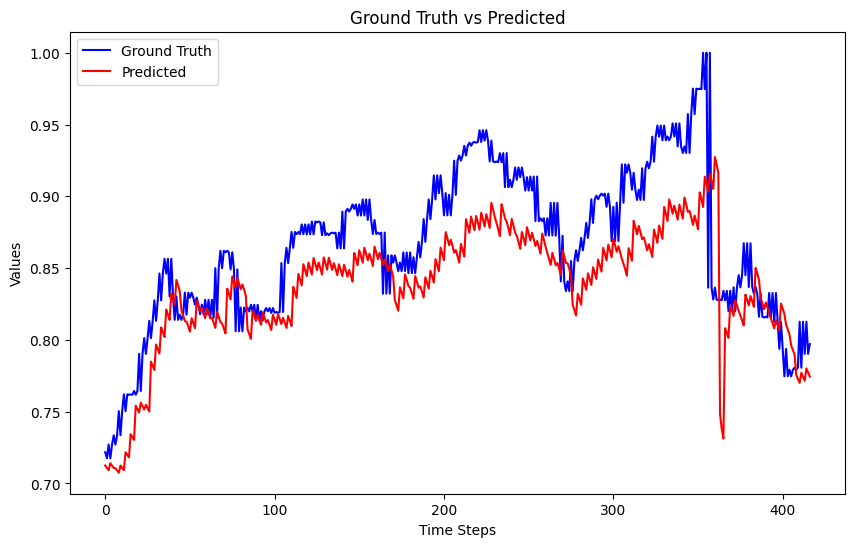

saved predictions and evals to test_result_25/WMT_nonsentiment_202402010402/WMT_nonsentiment_202402010402_predicted_data.csv and test_result_25/WMT_nonsentiment_202402010402/WMT_nonsentiment_202402010402_eval_data.csv


In [13]:
# sentiment_types = ["sentiment", "nonsentiment"]
# Test of 25 
# names = ['AAPL.csv', 'ABBV.csv', 'ACGLO.csv', 'AFGD.csv', 'AGM-A.csv', 'AKO-A.csv', 'AMD.csv', 'AMZN.csv', 'ARTLW.csv', 'BABA.csv', 'BCDAW.csv', 'BH-A.csv', 'BHFAL.csv', 'BRK-B.csv', 'BROGW.csv', 'C.csv', 'CIG-C.csv', 'CLSN.csv', 'COST.csv', 'CRD-A.csv', 'CVX.csv', 'DIS.csv', 'FDEV.csv', 'FITBO.csv', 'GAINL.csv', 'GE.csv', 'GECCM.csv', 'GOOG.csv', 'GRP-UN.csv', 'GTN-A.csv', 'HCXY.csv', 'HVT-A.csv', 'INBKZ.csv', 'INTC.csv', 'KO.csv', 'MSFT.csv', 'NVDA.csv', 'OCFCP.csv', 'PBR-A.csv', 'PYPL.csv', 'QQQ.csv', 'QVCD.csv', 'SBUX.csv', 'T.csv', 'TSLA.csv', 'TSM.csv', 'UCBIO.csv', 'WFC.csv', 'WMT.csv', 'WSO-B.csv']
# names = ['AAPL.csv', 'ABBV.csv', 'AMZN.csv', 'BABA.csv', 'BRK-B.csv', 'C.csv', 'COST.csv', 'CVX.csv','DIS.csv', 'GE.csv',
#          'INTC.csv', 'MSFT.csv', 'nvda.csv', 'pypl.csv','QQQ.csv', 'SBUX.csv', 'T.csv', 'TSLA.csv', 'WFC.csv',
#          'KO.csv', 'AMD.csv', 'TSM.csv', 'GOOG.csv', 'WMT.csv']
# Tes of 50
names = ['aal.csv', 'AAPL.csv', 'ABBV.csv', 'AMD.csv', 'amgn.csv', 'AMZN.csv', 'BABA.csv',
              'bhp.csv', 'bidu.csv', 'biib.csv', 'BRK-B.csv', 'C.csv', 'cat.csv', 'cmcsa.csv', 'cmg.csv',
                'cop.csv', 'COST.csv', 'crm.csv', 'CVX.csv', 'dal.csv', 'DIS.csv', 'ebay.csv', 'GE.csv',
                  'gild.csv', 'gld.csv', 'GOOG.csv', 'gsk.csv', 'INTC.csv', 'KO.csv', 'mrk.csv', 'MSFT.csv',
                    'mu.csv', 'nke.csv', 'nvda.csv', 'orcl.csv', 'pep.csv', 'pypl.csv', 'qcom.csv', 'QQQ.csv',
                      'SBUX.csv', 'T.csv', 'tgt.csv', 'tm.csv', 'TSLA.csv', 'TSM.csv', 'uso.csv', 'v.csv', 'WFC.csv',
                        'WMT.csv', 'xlf.csv'] 
names = [name.lower() for name in names]
# Short
# names = ['KO.csv', 'AMD.csv', 'TSM.csv', 'GOOG.csv','WMT.csv']
# names = ['GOOG.csv']
pred_names = ['KO','AMD',"TSM","GOOG",'WMT']
pred_names = [pred_name.lower() for pred_name in pred_names]
num_stocks = len(names)
# num_stocks = 5
# num_stocks = 25
# num_stocks = 50
for i in range(3):
  if_pred = False
  if  i == 2:
      if_pred = True
  # for sentiment_type in sentiment_types:
  for name in names:
      csv_data = pd.read_csv(os.path.join("data", name))
      symbol_name = name.split('.')[0]
      print(symbol_name)
      sentiment_predict(csv_data, symbol_name, num_stocks, if_pred)
      nonsentiment_predict(csv_data, symbol_name, num_stocks, if_pred)